In [1]:
from active_optics_init import *

>>> ON_AXIS_SRC.json
>>> ATMOSPHERE.json
>>> WFS_GUIDE_STARS.json
>>> WFS.json
>>> ON_AXIS_IMGR.json
>>> TT7_GUIDE_STAR.json
>>> TT7.json
>>> GMT.json
WFS seeing: 0.75arcsec
WFS FWHM: 5.000000 pixel
6912
detector resolution: 384pixel
WFS pixel scale:  0.42arcsec
WFS field-of-view 3.33arcsec


In [9]:
from LinearActiveOptics import BuildLinearActiveOptics, Wavefronts, ModelData, LinearActiveOptics, noiseRejectionFactor

In [3]:
laco = LinearActiveOptics('ActiveOptics_27BM','DATA/onAxisWavefront_401')

(14, 39)
(14, 37)
@(CalibrationMatrix)> Updating the pseudo-inverse...
[2, 2, 2, 2, 2, 2, 0]


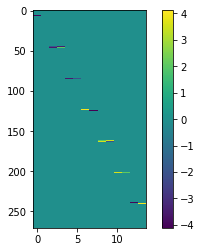

In [5]:
J = laco._s_Mtt7.todense()
plt.imshow(J,aspect=0.1)
plt.colorbar()

221.872819462


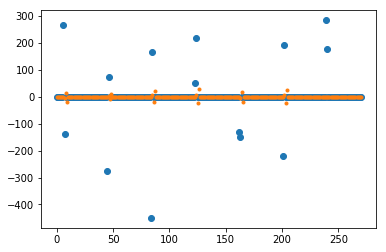

In [6]:
v = J.dot(np.random.randn(14,1))*56#*ceo.constants.MAS2RAD
plt.plot(v,'o')
print np.std(v[v!=0])
w = laco._s_Qwfs.dot(v)
plt.plot(w,'.')

In [7]:
np.std(laco.W.dot(v*ceo.constants.MAS2RAD))*1e6

0.78132177560682492

In [8]:
np.std(laco.W.dot(w*ceo.constants.MAS2RAD))*1e6

1.2631371526072331e-07

## Wavefront samples

In [14]:
nrf = noiseRejectionFactor({'T':5e-3,'tau':5e-3,'g':0.5})
print nrf

0.538576520298


In [15]:
(F,rmsF) = laco.wavefrontSamples(N_SAMPLE=100,tt7_rms=np.sqrt(nrf)*56*ceo.constants.MAS2RAD)
#(F,rmsF) = laco.wavefrontSamples(N_SAMPLE=100,wfs_rms=60*ceo.constants.MAS2RAD)

In [16]:
F.shape

(401, 401, 100)

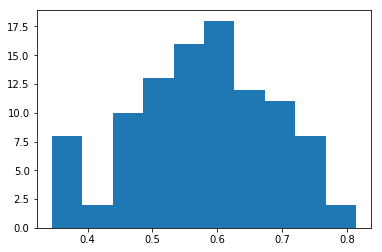

In [17]:
plt.hist(rmsF*1e6);

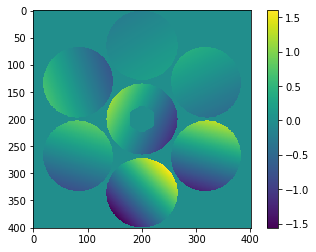

In [18]:
plt.imshow(F[:,:,0]*1e6)
plt.colorbar()

In [19]:
from scipy.signal import fftconvolve
from scipy.special import gamma, kv

def atmSF(_rho_,_r0_,_L0_):
    c = 2*gamma(11./6.)*(24.*gamma(6./5.)/5.)**(5./6.)/(2**(5./6.)*np.pi**(8./3.))
    red = np.asarray(2*np.pi*_rho_/_L0_)
    out = np.zeros(red.shape)
    idx = red!=0
    redd = red[idx]
    out[idx] = c*(_L0_/_r0_)**(5./3.)*(gamma(5./6.)/2**(1./6.) - redd**(5./6.)*kv(5./6.,redd))
    return out

def atmOTF(_rho_,_r0_,_L0_):
    return np.exp(-0.5*atmSF(_rho_,_r0_,_L0_))

In [20]:
def telOTF(A,F,wavelength):
    k = 2.*np.pi/wavelength
    W = A*np.exp(1j*k*F)  
    v = np.sum(A)
    S1 = np.fliplr(np.flipud(W))
    S2 = np.conj(W)
    AW = fftconvolve(S1,S2)
    return AW

In [21]:
def PSSn(A,F,L=25.5,wavelength=500e-9,r0=15e-2,L0=25):
    nPx = A.shape[0]
    u = np.arange(2*nPx-1,dtype=np.float)*L/(nPx-1)
    u = u-u[-1]/2
    x,y = np.meshgrid(u,u)
    rho = np.hypot(x,y)
    C = atmOTF(rho,r0,L0)
    D = telOTF(A,0,wavelength)*C
    sD2 = np.sum(np.abs(D)**2)
    if F.ndim<3:
        F = F[...,np.newaxis]
    nF = F.shape[2]
    out = np.zeros(nF)
    for k in range(nF):
        N = telOTF(A,F[:,:,k],wavelength)*C
        out[k] = np.sum(np.abs(N)**2)/sD2
    return out

In [22]:
A = laco.wavefronts['pupil_mask'].reshape(401,401)
sa = A.shape

In [28]:
wavelength = 0.5e-6
r0wlgth = 15e-2*(wavelength/0.5e-6)**1.2
print r0wlgth

0.15


In [29]:
pssn = PSSn(A,F,wavelength=wavelength,r0=r0wlgth)

0.979252747015


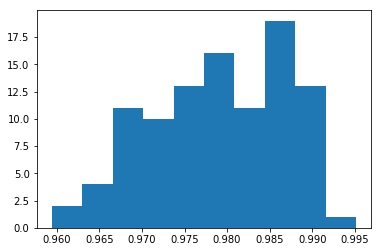

In [31]:
print np.mean(pssn)
plt.hist(pssn);

In [37]:
def PSSnAvg(A,F,L=25.5,wavelength=500e-9,r0=15e-2,L0=25):
    nPx = A.shape[0]
    u = np.arange(2*nPx-1,dtype=np.float)*L/(nPx-1)
    u = u-u[-1]/2
    x,y = np.meshgrid(u,u)
    rho = np.hypot(x,y)
    C = atmOTF(rho,r0,L0)
    D = telOTF(A,0,wavelength)*C
    sD2 = np.sum(np.abs(D)**2)
    if F.ndim<3:
        F = F[...,np.newaxis]
    nF = F.shape[2]
    out = np.zeros(nF)
    telOTFavg = np.zeros((2*nPx-1,2*nPx-1),dtype=np.complex)
    for k in range(nF):
        telOTFavg += telOTF(A,F[:,:,k],wavelength)
    N = telOTFavg*C/nF
    out = np.sum(np.abs(N)**2)/sD2
    return out

In [33]:
PSSn(A,F)

0.99797123773358309

In [44]:
tt7 = ModelData(None,variate=None)

In [45]:
tt7.variate

In [48]:
laco.wfs.spotFWHM_arcsec

0.8328244882823939